# Text Analytics Project

In [27]:
#Import packages
import pandas as pd
import nltk
nltk.download( 'vader_lexicon' )
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import timeit
import datetime
import numpy as np

from collections import Counter
import xlsxwriter
from pandas import DataFrame
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\treyh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
#Read in reviews datasets
reviews = pd.read_csv('C:/Users/treyh/OneDrive/Documents/Documents/IAA/Text Analytics/tiktok_app_reviews.csv')
weekly_scores = pd.read_csv('C:/Users/treyh/OneDrive/Documents/Documents/IAA/Text Analytics/perweek.csv')
scored_reviews = pd.read_csv('C:/Users/treyh/OneDrive/Documents/Documents/IAA/Text Analytics/scored_reviews.csv')

#Fix date and trim to after 2018
scored_reviews["posted_date"] = pd.to_datetime(scored_reviews["posted_date"])
scored_reviews["posted_date"] = scored_reviews["posted_date"].dt.date
scored_reviews = scored_reviews[scored_reviews["posted_date"] >= datetime.datetime.strptime('2018-01-01', "%Y-%m-%d").date()]



C:\Users\treyh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\treyh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
#Example of text with an emoji
reviews.iloc[29,1]


'No glitches or hick ups as of yet, rather enjoying using the app 👍 Update, tried to log into my account via phone, says server error but our internet is fine, tried signing in with my facebook account, still server error, is the site under maintenance by any chance? Or will I need to uninstall then re-install?'

In [4]:
#Get scoring of example text
sentiment = SentimentIntensityAnalyzer()
score = sentiment.polarity_scores(reviews.iloc[327,1])
score
#print( score['neg'])
#print( score['pos'])


{'neg': 0.0, 'neu': 0.72, 'pos': 0.28, 'compound': 0.8126}

## Modelling

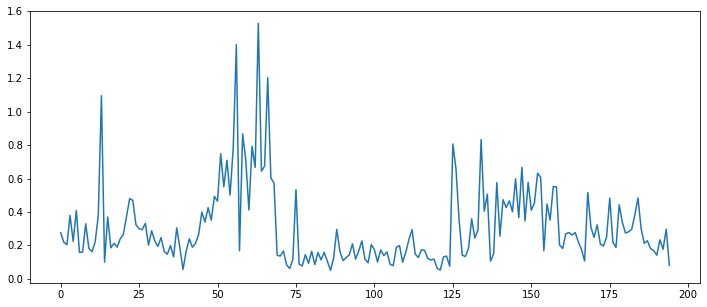

In [82]:
plt.figure( figsize = ( 12, 5))
plt.plot(weekly_scores["Compound"] * (weekly_scores["upvotes"]))
#positive_avg



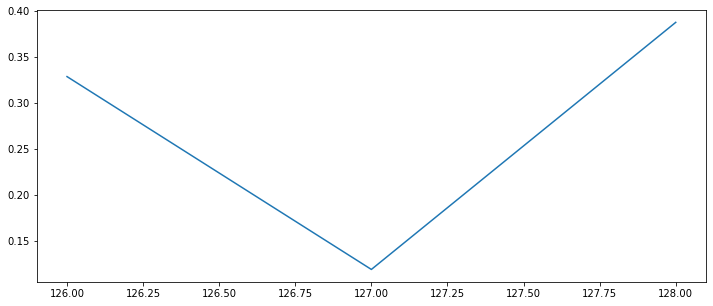

In [9]:
#Plot dip in time plot
test = weekly_scores[(weekly_scores["WeekDate"] >= '2020-06-01') & (weekly_scores["WeekDate"] <= '2020-06-15')]

plt.figure( figsize = ( 12, 5))
plt.plot(test["Compound"])

In [20]:
#Look at dataset around time of weird dip in the line plot
test2 = scored_reviews[(scored_reviews["posted_date"] >= datetime.datetime.strptime('2020-06-01', "%Y-%m-%d").date()) & (scored_reviews["posted_date"] <= datetime.datetime.strptime('2020-06-15', "%Y-%m-%d").date())]
test2

,Unnamed: 0,review_id,review_text,upvotes,app_version,posted_date,Positive,Negative,Neutral,Compound
606780,606780,gp:AOqpTOFiFMv8Ds6OzJFwZfweMqyuIx9KlK0toZhAJoR...,Super and excellent app,1,16.4.4,2020-06-09,0.792,0.000,0.208,0.8225
656357,656357,gp:AOqpTOFYFq93ZQ_o1yRUC_6lKpfrgcZlSSE_ngUb6Ti...,I have complete 2k followers but still i dont ...,0,16.0.4,2020-06-10,0.000,0.000,1.000,0.0000
770653,770653,gp:AOqpTOEkHjtiUhlFxN8A3b8xMCxwAD371oUaOh8qrwN...,Amazing app very entertaining,23,16.3.5,2020-06-09,0.778,0.000,0.222,0.7902
792883,792883,gp:AOqpTOGChMoHAHEh7Q451z7rPwkUn8w4d1guY6R2woy...,So nice tiktok of the channel,3,16.0.4,2020-06-01,0.382,0.000,0.618,0.4754
798656,798656,gp:AOqpTOFPwTZQjIkzfJV2vYUsf-mdCvKEfLQWnMc6pam...,It says bad words... Wtf,4,NaN,2020-06-08,0.000,0.709,0.291,-0.8074
866941,866941,gp:AOqpTOHzHjobNNU7DGacAp1wtbAnO0yDQ14K1l09UOj...,Thos is lingnsokd mavi.si dkmfk mavsk malekidb...,0,NaN,2020-06-03,0.000,0.000,1.000,0.0000
1026280,1026280,gp:AOqpTOEy4dLrmOTe-c9PIu-DHxbtNlNvmKXDXONj5BF...,Nice to tik tok app,2,16.0.43,2020-06-02,0.412,0.000,0.588,0.4215
1069724,1069724,gp:AOqpTOE8X0pXze9VqsZmZw8NIDsqprG0LeAX2lAQmcp...,It's really bad.and net waste in this app.,2,16.0.43,2020-06-02,0.000,0.304,0.696,-0.4703
1135219,1135219,gp:AOqpTOEWg5e5-qcb-D2cy5GNgQLIg11uqYSH5_P-Jdr...,I like and love it,0,NaN,2020-06-02,0.770,0.000,0.230,0.7717
1217878,1217878,gp:AOqpTOHi3c9iIXlL4ZJiCOjWij5t2x4qRU2HTJiNiAy...,I have 4k fan But have live copsan (uesr id =@...,4,16.3.5,2020-06-11,0.277,0.000,0.723,0.5574


In [6]:
post_covid = scored_reviews[(scored_reviews["posted_date"] >= datetime.datetime.strptime('2020-03-01', "%Y-%m-%d").date()) ]
pre_covid = scored_reviews[(scored_reviews["posted_date"] < datetime.datetime.strptime('2020-03-01', "%Y-%m-%d").date()) ]
print(len(pre_covid["Compound"]), len(post_covid["Compound"]))

1565533 1716534


In [30]:
q1, q3= np.percentile(post_covid["Compound"],[25,75])
iqr = q3-q1
iqr
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
print(lower_bound, upper_bound)
post_covid[post_covid["Neutral"] < post_covid["Negative"]]

-0.95535 1.59225


,Unnamed: 0,review_id,review_text,upvotes,app_version,posted_date,Positive,Negative,Neutral,Compound
1201,1201,gp:AOqpTOFVC91_Lrc5fK9JWFiK1P5qMSkO_CTftQb9aYK...,"No problems, no adds great pics videos between...",1,20.9.3,2021-09-06,0.355,0.350,0.296,0.2732
2430,2430,gp:AOqpTOFo0m0HNalqqQpROX18p7z3YX1A698i6Mp0C6P...,"Terrible app, account creation was difficult, ...",1,20.2.2,2021-07-01,0.147,0.440,0.414,-0.8313
2576,2576,gp:AOqpTOH3aiMHpSsqXTg5-tKwbgHqfTzAy_18rVis9Rm...,Really good app with no upload problems 😊,0,21.1.41,2021-09-12,0.264,0.405,0.331,-0.1796
2952,2952,gp:AOqpTOHBA3BU5TsG0bct5QYy6JQzlrMGsR1Oy3pdeIx...,"Absolutely love the app! No unwanted ads, no p...",2,20.0.5,2021-06-28,0.227,0.470,0.303,-0.4213
3583,3583,gp:AOqpTOHMi7ThkJpSGeEJhjOxRgtREVILjsiuxF8jl-I...,Great app but one problem payment schedule not...,0,20.4.4,2021-07-21,0.162,0.457,0.381,-0.6860
...,...,...,...,...,...,...,...,...,...,...
3644731,3644731,gp:AOqpTOHwp6vGl-VvAgUxXArBM64-2qeutFRA8VPXgfL...,ass,0,NaN,2020-12-04,0.000,1.000,0.000,-0.5423
3644915,3644915,gp:AOqpTOFzKK397XYgItRBqQjqXZ8DWExc4wcr2Hd3d4A...,Ass,0,NaN,2020-10-10,0.000,1.000,0.000,-0.5423
3644997,3644997,gp:AOqpTOHDeaDhMGIDJFIIayP6L8oQiZnvffuixyDN8MC...,IDK,0,NaN,2020-06-18,0.000,1.000,0.000,-0.1027
3645758,3645758,gp:AOqpTOFJ0RnxAGePcxxBeoaK2uU-VefM5_2l7jOXsw9...,Idk,0,NaN,2021-09-16,0.000,1.000,0.000,-0.1027


In [7]:
pos_pre = pre_covid.nlargest(1000, "Compound")
neg_pre = pre_covid.nsmallest(1000, "Compound")
pos_post = post_covid.nlargest(1000, "Compound")
neg_post = post_covid.nsmallest(1000, "Compound")

In [25]:
pos_post["review_text"] * (pos_post["upvotes"] + 1)

659947     How to make pickle make your day good I like I...
127336     Like To do that you can see two different ways...
489312     Lovely l like this l love tiktok thanka you ar...
508217     I had a problem with this I have 4 account i n...
1128414    Hi I know it's going well and it is my first t...
                                 ...                        
121520     This is a super entertaining app we all love i...
132490     It's soo fun and I love it like I can not slee...
161961     i love the app dont listen to those who say th...
163195     When i was joined tiktok. Reay it's make my li...
190668     overall its really good like its a amazing app...
Length: 1000, dtype: object

In [86]:
from nltk.corpus import stopwords

counter = Counter(" ".join((neg_post["review_text"]*(neg_post["upvotes"] + 1)).astype(str)).split()).most_common(1000)
filtered_words_all = []
for (word, count) in counter:
    if word.lower() not in stopwords.words('english'):
        filtered_words_all.append(tuple((word, count)))

In [87]:
filtered_words_all


[('big', 12102),
 ('videos', 11358),
 ('app', 11125),
 ('problem', 8999),
 ('really', 8489),
 ('people', 7329),
 ('bad', 5780),
 ('comments', 4985),
 ('things', 4900),
 ('tiktok', 4558),
 ('many', 4557),
 ('problems', 4467),
 ('video', 4336),
 ('getting', 4293),
 ('another', 4251),
 ('feel', 4205),
 ('say', 4170),
 ('creators', 4124),
 ('deleted', 4105),
 ('favorite', 4098),
 ('problems.', 4094),
 ('hours', 4090),
 ('spend', 4062),
 ('always', 4062),
 ('mean', 4055),
 ('deleting', 4043),
 ('without', 4042),
 ('reason,', 4041),
 ('random', 4037),
 ('me,', 4033),
 ('bored,', 4032),
 ('example', 4032),
 ('bothers', 4032),
 ('bugs', 4032),
 ('amazing!!', 4031),
 ('interesting', 4031),
 ('problems,', 4031),
 ('minor', 4031),
 ('community,', 4031),
 ('them.This', 4029),
 ('still', 3871),
 ('know', 3648),
 ('much', 3623),
 ('using', 3238),
 ('screen', 3225),
 ('dont', 3142),
 ('let', 3128),
 ('im', 3097),
 ('tried', 3079),
 ('like', 3078),
 ('log', 3048),
 ('it,', 3042),
 ('says', 3033),
 ('g

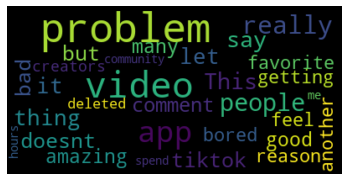

In [88]:
df = DataFrame(filtered_words_all,columns=['Word','Count']).drop(0) 
df["WordCloud"] = (df['Word'] + " ") *df['Count']
df

text = " ".join(review for review in df.WordCloud)


wordcloud = WordCloud(stopwords = [""], collocations=False,max_font_size=50, max_words=30, background_color="black").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Topic Detection

In [17]:
#Create subset for post-covid
topic_det_set = scored_reviews[(scored_reviews["posted_date"] >= datetime.datetime.strptime('2020-03-01', "%Y-%m-%d").date()) ]


In [8]:
############################################ Start of topic detection #####################################################
##Functions to perform lemmatize and stem preprocessing steps on the data set.
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [9]:
##Preview after preprocessing.
doc_sample = " ".join(neg_pre['review_text'].astype(str))
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
#print(words)
print('\n\n tokenized and lemmatized document: ')
stemmer = SnowballStemmer('english')
#print(preprocess(doc_sample))


original document: 


 tokenized and lemmatized document: 


In [10]:
##Preprocess the text

processed_docs = neg_pre['review_text'].astype(str).map(preprocess)
processed_docs[:10]

##Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
        
##Filter dictionary by: less than 15 appearances, 100000 most frequent tokens
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

0 hate
1 take
2 chang
3 comment
4 exlent
5 good
6 immedi
7 letter
8 limit
9 minimum
10 perfect


In [11]:
## For each document we create a dictionary reporting how many words and how many times those words appear, save in bow_corpus

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[10]

bow_doc_10 = bow_corpus[1]
for i in range(len(bow_doc_10)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_10[i][0], 
                                               dictionary[bow_doc_10[i][0]], 
                                                bow_doc_10[i][1]))

Word 2 ("chang") appears 2 time.
Word 3 ("comment") appears 1 time.
Word 4 ("good") appears 1 time.
Word 5 ("stupid") appears 2 time.
Word 6 ("thing") appears 1 time.


In [12]:
##Create tf-idf model object, then apply transformation to the entire corpus. Preview TF-IDF scores for our first document.

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.9894357503223272), (1, 0.1449720524242288)]


In [13]:
##Train our lda model using gensim.models.LdaMulticore 

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

##For each topic, we will explore the words occuring in that topic and its relative weight.

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.115*"good" + 0.101*"like" + 0.065*"thing" + 0.045*"time" + 0.038*"wrong" + 0.038*"problem" + 0.036*"get" + 0.030*"delet" + 0.027*"best" + 0.025*"suck"
Topic: 1 
Words: 0.206*"video" + 0.103*"problem" + 0.039*"qualiti" + 0.035*"peopl" + 0.029*"think" + 0.029*"upload" + 0.028*"good" + 0.026*"view" + 0.026*"bulli" + 0.025*"post"
Topic: 2 
Words: 0.106*"hate" + 0.058*"sick" + 0.055*"video" + 0.047*"kill" + 0.042*"download" + 0.040*"tiktok" + 0.039*"peopl" + 0.036*"best" + 0.032*"hell" + 0.030*"wrong"
Topic: 3 
Words: 0.089*"stop" + 0.087*"video" + 0.046*"thing" + 0.041*"love" + 0.037*"amaz" + 0.034*"ban" + 0.029*"start" + 0.027*"like" + 0.025*"live" + 0.023*"tiktok"
Topic: 4 
Words: 0.210*"hate" + 0.056*"worst" + 0.037*"time" + 0.036*"suck" + 0.035*"stupid" + 0.032*"updat" + 0.030*"phone" + 0.027*"great" + 0.026*"tiktok" + 0.023*"peopl"
Topic: 5 
Words: 0.232*"like" + 0.068*"dont" + 0.051*"love" + 0.047*"peopl" + 0.037*"tiktok" + 0.028*"know" + 0.026*"problem" + 0.022*"t

In [14]:
##Using tfdif instead of bow corpus

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.113*"music" + 0.102*"best" + 0.073*"updat" + 0.048*"want" + 0.047*"hate" + 0.031*"live" + 0.028*"phone" + 0.028*"like" + 0.027*"know" + 0.026*"love"
Topic: 1 Word: 0.107*"stop" + 0.061*"block" + 0.054*"dumb" + 0.052*"tiktok" + 0.052*"star" + 0.051*"mean" + 0.050*"addict" + 0.038*"hate" + 0.033*"peopl" + 0.029*"game"
Topic: 2 Word: 0.069*"like" + 0.055*"version" + 0.053*"bore" + 0.046*"problem" + 0.041*"post" + 0.041*"peopl" + 0.035*"feel" + 0.035*"tiktok" + 0.031*"video" + 0.029*"song"
Topic: 3 Word: 0.112*"bulli" + 0.110*"video" + 0.078*"good" + 0.053*"peopl" + 0.037*"like" + 0.036*"problem" + 0.034*"think" + 0.025*"amaz" + 0.022*"hater" + 0.021*"work"
Topic: 4 Word: 0.055*"dont" + 0.048*"know" + 0.041*"like" + 0.040*"ban" + 0.039*"love" + 0.037*"phone" + 0.034*"great" + 0.032*"cool" + 0.031*"hate" + 0.028*"follow"
Topic: 5 Word: 0.050*"thing" + 0.050*"life" + 0.041*"ban" + 0.038*"right" + 0.037*"hat" + 0.036*"reason" + 0.036*"girl" + 0.032*"good" + 0.031*"problem" + 

In [20]:
topic_det_set['review_text'][1]

"Great app works really well so many features so many new features lots of popular trends and so many things you can do on the app like find friends, post videos, get likes ,Duets, shares, and so much more so yes or even get sponsored on tik tok besides all the scams the app is pretty content and sometimes the foryou page won't load but other than that it's a great app that continues to improve so yes 5 Stars"

In [17]:
##We will check where our test document would be classified.

for index, score in sorted(lda_model[bow_corpus[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.21757495403289795	 
Topic: 0.279*"cool" + 0.039*"famous" + 0.030*"game" + 0.023*"music" + 0.022*"thing" + 0.021*"danc" + 0.021*"buena" + 0.021*"video" + 0.020*"friend" + 0.019*"post"

Score: 0.1432441622018814	 
Topic: 0.342*"good" + 0.040*"video" + 0.020*"thank" + 0.016*"viral" + 0.014*"kumar" + 0.012*"tiktok" + 0.011*"meri" + 0.011*"nahi" + 0.011*"foryou" + 0.009*"mere"

Score: 0.1337837427854538	 
Topic: 0.078*"enjoy" + 0.032*"goog" + 0.027*"yeet" + 0.025*"brilliant" + 0.024*"platform" + 0.022*"mejor" + 0.022*"encanta" + 0.019*"ajay" + 0.017*"mass" + 0.016*"talent"

Score: 0.1274244785308838	 
Topic: 0.430*"like" + 0.038*"follow" + 0.028*"year" + 0.020*"perfect" + 0.019*"dope" + 0.016*"live" + 0.014*"noic" + 0.014*"help" + 0.013*"okay" + 0.010*"instal"

Score: 0.12209010869264603	 
Topic: 0.713*"nice" + 0.040*"superb" + 0.024*"star" + 0.023*"supar" + 0.019*"bahut" + 0.013*"nise" + 0.009*"work" + 0.006*"updat" + 0.006*"hard" + 0.006*"liy"

Score: 0.0827363133430481	 
Topic:

In [21]:
for index, score in sorted(lda_model_tfidf[bow_corpus[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.27190929651260376	 
Topic: 0.028*"foryou" + 0.023*"follow" + 0.021*"kumar" + 0.019*"account" + 0.015*"tiktok" + 0.014*"video" + 0.013*"view" + 0.013*"live" + 0.013*"singh" + 0.011*"famous"

Score: 0.16250212490558624	 
Topic: 0.155*"addict" + 0.129*"video" + 0.105*"wonder" + 0.071*"viral" + 0.048*"interest" + 0.040*"dope" + 0.032*"noic" + 0.020*"danc" + 0.016*"thing" + 0.016*"friend"

Score: 0.16150128841400146	 
Topic: 0.140*"app" + 0.054*"star" + 0.052*"supar" + 0.039*"bhai" + 0.032*"osam" + 0.027*"nise" + 0.027*"work" + 0.026*"download" + 0.025*"naic" + 0.022*"mere"

Score: 0.15360549092292786	 
Topic: 0.553*"great" + 0.067*"supper" + 0.021*"awsm" + 0.015*"amez" + 0.015*"luck" + 0.012*"mind" + 0.012*"joss" + 0.011*"word" + 0.011*"unfreez" + 0.010*"blow"

Score: 0.1195283755660057	 
Topic: 0.098*"awsom" + 0.071*"happi" + 0.038*"king" + 0.038*"acha" + 0.023*"help" + 0.023*"life" + 0.019*"support" + 0.018*"platform" + 0.015*"bhot" + 0.014*"hard"

Score: 0.05217614397406578	 
